In [2]:
# 1. Tải bộ dữ liệu

!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

!unzip dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 10.7MB/s]
Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [6]:
%pip install Unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00


In [7]:
# 2. Import các thư viện cần thiết

import torch # type: ignore
import torch.nn as nn # type: ignore

seed = 1
torch.manual_seed(seed)

import os # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import re # type: ignore
import nltk # type: ignore
import unidecode # type: ignore

nltk.download('stopwords') # type: ignore
from nltk.corpus import stopwords # type: ignore
from nltk.stem.porter import PorterStemmer # type: ignore

from torch.utils.data import Dataset, DataLoader # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# 3. Đọc bộ dữ liệu
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
                dataset_path,
                names=headers,
                encoding='ISO-8859-1')

classes = {
        class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
        }

In [12]:
# 4. Tiền xử lý dữ liệu
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [25]:
# 5. Xây dựng bộ từ vựng
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size  = len(vocab)

def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_idx = word_to_idx[w]
        except:
            w_idx = word_to_idx['UNK']
        tokens.append(w_idx)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [26]:
# 6. Chia bộ dữ liệu train, val, test
val_size = 0.2
text_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
                                                texts,
                                                labels,
                                                test_size=val_size,
                                                random_state=seed,
                                                shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(
                                                X_train,
                                                y_train,
                                                test_size=val_size,
                                                random_state=seed,
                                                shuffle=is_shuffle)

In [47]:
# 7. Xây dựng pytorch datasets
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None, classes=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)

        label = self.classes.get(label)
        label = torch.tensor(label, dtype=torch.long)
        text = torch.tensor(text, dtype=torch.long)

        return text, label


# 8. Khai báo dataloader
max_seq_len = 32
train_dataset = FinancialNews(
                            X_train,
                            y_train,
                            word_to_idx=word_to_idx,
                            max_seq_len=max_seq_len,
                            transform=transform,
                            classes=classes)
val_dataset = FinancialNews(
                            X_val,
                            y_val,
                            word_to_idx=word_to_idx,
                            max_seq_len=max_seq_len,
                            transform=transform,
                            classes=classes)
test_dataset = FinancialNews(
                            X_test,
                            y_test,
                            word_to_idx=word_to_idx,
                            max_seq_len=max_seq_len,
                            transform=transform,
                            classes=classes)
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
                        train_dataset,
                        batch_size=train_batch_size,
                        shuffle=True,
                        num_workers=1
                        )
val_loader = DataLoader(
                        val_dataset,
                        batch_size=test_batch_size,
                        shuffle=False,
                        num_workers=1
                        )
test_loader = DataLoader(
                        test_dataset,
                        batch_size=test_batch_size,
                        shuffle=False,
                        num_workers=1
                        )

# 9. Xây dựng mô hình
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hbn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
                            vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            n_classes=n_classes,
                            dropout_prob=dropout_prob).to(device)

# 10. Cài đặt hàm loss và optimizer
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)

EPOCH 1: 	Train loss: 0.9830 	Val loss: 0.9437 	Val acc: 0.5866
EPOCH 2: 	Train loss: 0.9526 	Val loss: 0.9335 	Val acc: 0.5866
EPOCH 3: 	Train loss: 0.9424 	Val loss: 0.9310 	Val acc: 0.5856
EPOCH 4: 	Train loss: 0.9308 	Val loss: 0.9306 	Val acc: 0.5856
EPOCH 5: 	Train loss: 0.9339 	Val loss: 0.9304 	Val acc: 0.5856
EPOCH 6: 	Train loss: 0.9349 	Val loss: 0.9301 	Val acc: 0.5856
EPOCH 7: 	Train loss: 0.9415 	Val loss: 0.9301 	Val acc: 0.5856
EPOCH 8: 	Train loss: 0.9333 	Val loss: 0.9313 	Val acc: 0.5856
EPOCH 9: 	Train loss: 0.9377 	Val loss: 0.9307 	Val acc: 0.5856
EPOCH 10: 	Train loss: 0.9295 	Val loss: 0.9298 	Val acc: 0.5856
EPOCH 11: 	Train loss: 0.9340 	Val loss: 0.9300 	Val acc: 0.5856
EPOCH 12: 	Train loss: 0.9324 	Val loss: 0.9295 	Val acc: 0.5866
EPOCH 13: 	Train loss: 0.9272 	Val loss: 0.9295 	Val acc: 0.5866
EPOCH 14: 	Train loss: 0.9312 	Val loss: 0.9296 	Val acc: 0.5866
EPOCH 15: 	Train loss: 0.9333 	Val loss: 0.9294 	Val acc: 0.5866
EPOCH 16: 	Train loss: 0.9287 	Val

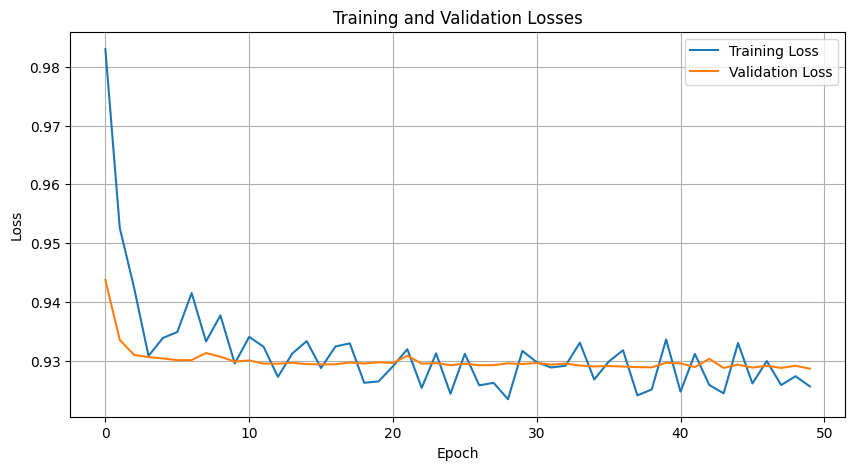

In [48]:
# 11. Thực hiện huấn luyện
def fit(model, train_loader, val_loader, criterion, optimizer, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch+1}: \tTrain loss: {train_loss:.4f} \tVal loss: {val_loss:.4f} \tVal acc: {val_acc:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# 12. Đánh giá mô hình
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print(f'Val accuracy', val_acc)
print(f'Test accuracy', test_acc)

Evaluation on val/test dataset
Val accuracy 0.5855670103092784
Test accuracy 0.6134020618556701
